In [1]:
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import math
import calendar

In [2]:
os.chdir("/Users/giandomenico/Documents/SAPIENZA/Papers/PBL_Failure Hazard/data")


In [3]:
data = gpd.read_file("falls_3857_membro.shp").set_index('id')
data['Data'] = pd.to_datetime(data['Data'])
data = data.sort_values(by='Data')
data['Litologia'] = data['Litologia'].replace({'Marna': 'Marl','marna': 'Marl', 'Arenaria':'Sandstone', 'arenaria':'Sandstone'})

# Select from May 2022 to May 2023
data = data.set_index(['Data'])
data = data.loc['2022-05-01': '2023-05-31']
time_interval = (data.index.max() - data.index.min()).days+1
areas = data['area_m'].values
times = data.index.values

In [4]:
area_pml = 14356
area_pml_marl = round(area_pml*0.3, 1)
area_pml_sandstone = round(area_pml*0.7, 1)

area_pa = 15444
area_pa_marl = round(area_pa*0.5, 1)
area_pa_sandstone = round(area_pa*0.5, 1)

In [7]:
#%% Descriptive Statistics on Rockfall events.
stat = data.describe()
stat

,Distanza,N_Pixel,GSD,area_cm,area_m,raggio
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,440.970760,116.116959,4.760099,2902.601450,0.290287,0.190351
std,43.457407,518.962674,0.469058,13556.443649,1.355684,0.237795
min,242.000000,6.000000,2.612000,96.240000,0.010000,0.056000
25%,407.500000,13.000000,4.399000,301.399000,0.030500,0.098500
50%,442.000000,24.000000,4.771000,509.659000,0.051000,0.127000
75%,479.500000,48.000000,5.176000,1194.092000,0.119000,0.195000
max,546.000000,5758.000000,5.894000,148827.348000,14.883000,2.177000


In [8]:
stat_lito = data.groupby('Litologia')['area_m'].describe()
stat_lito

,count,mean,std,min,25%,50%,75%,max
Litologia,,,,,,,,
Marl,71.0,0.160155,0.434500,0.010,0.0275,0.0500,0.0965,2.853
Sandstone,100.0,0.382680,1.732541,0.011,0.0325,0.0535,0.1240,14.883


In [13]:
# rockfalls by months
rf_mag_giu_lug22 = gpd.read_file("falls_mag_giu_lug_2022.shp")
rf_ago_set_ott22 = gpd.read_file("falls_ago_set_ott_2022.shp")
rf_nov_dic_gen2223 = gpd.read_file("falls_nov_dic_gen_2022-2023.shp")
rf_feb_mar_apr23 = gpd.read_file("falls_feb_mar_apr_2023.shp")
rf_may23 = gpd.read_file("falls_mag_2023.shp")
rf_fb_mar_apr_mag23 = pd.concat([rf_feb_mar_apr23, rf_may23], ignore_index=True)

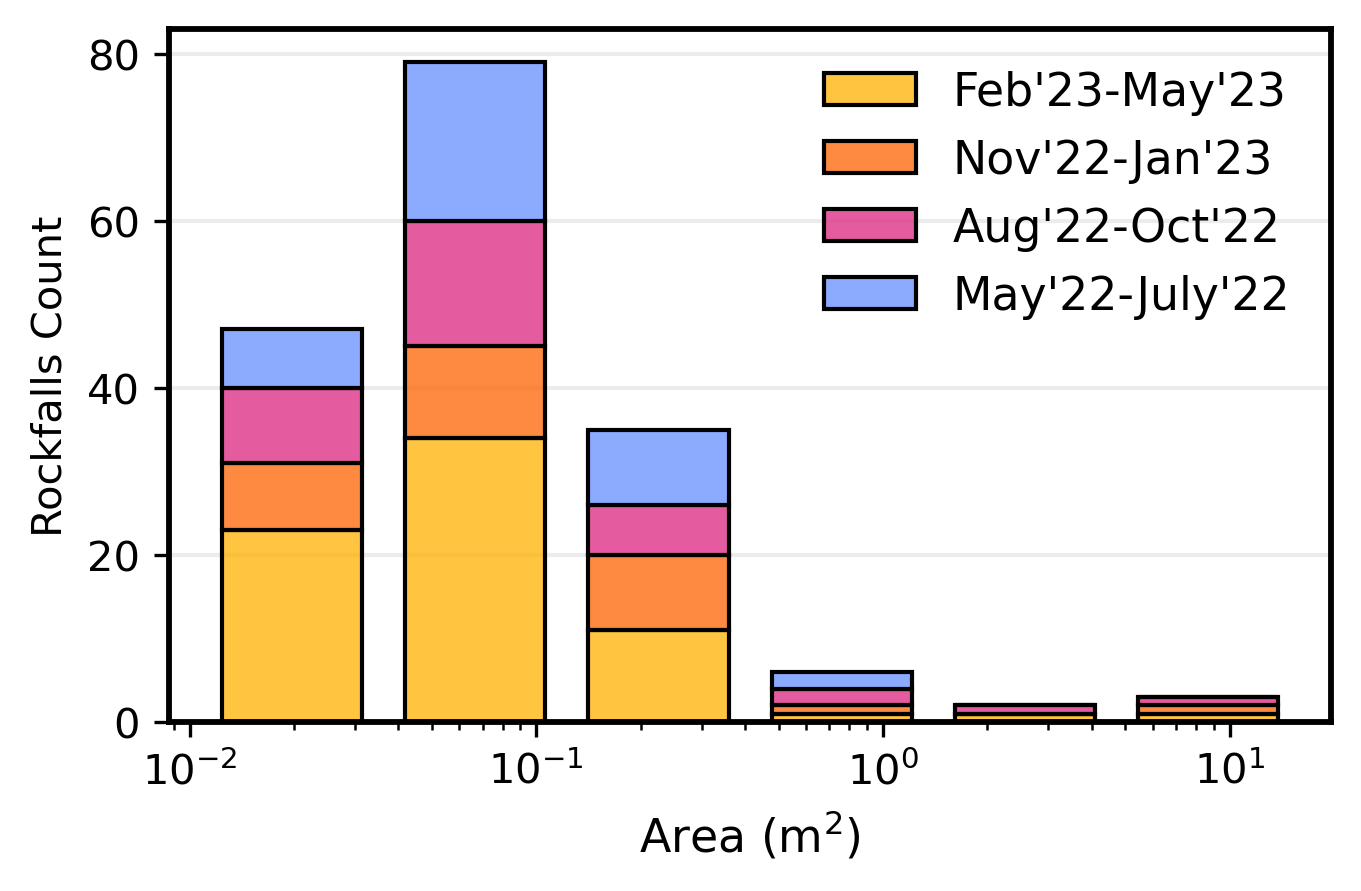

In [20]:
# HISTOGRAMS
# create unique value for each group
rf_mag_giu_lug22['group'] = 1
rf_ago_set_ott22['group'] = 2
rf_nov_dic_gen2223['group'] = 3
rf_fb_mar_apr_mag23['group'] = 4
# concat the groups
rf_groups_months = pd.concat([rf_mag_giu_lug22, rf_ago_set_ott22, rf_nov_dic_gen2223, rf_fb_mar_apr_mag23], ignore_index=True)
# rf_groups_months.to_file("crolli_grouped_months.gpkg", driver='GPKG')

#%% plot hist stacked by groups
# Define the color palette
colors = ['#648FFF', '#DC267F', '#FE6100', '#FFB000']
# Define the legend labels
legend_labels = ['Feb\'23-May\'23', 'Nov\'22-Jan\'23','Aug\'22-Oct\'22', 'May\'22-July\'22']

plt.figure(figsize=(5,3), dpi=300, facecolor='w', edgecolor='black')
sns.histplot(data=rf_groups_months, x='area_m', hue='group', stat='count',
             shrink=.8, multiple='stack', element='bars', bins=15, binwidth=.5, fill=1,
             log_scale=(True, False), cumulative=0, kde=0,
               palette=colors, zorder=2
             )


plt.xlabel('Area ($\mathrm{m^{2}}$)', fontsize=11)
plt.ylabel('Rockfalls Count', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

lw = 1.4
plt.gca().spines['top'].set_linewidth(lw)
plt.gca().spines['bottom'].set_linewidth(lw)
plt.gca().spines['left'].set_linewidth(lw)
plt.gca().spines['right'].set_linewidth(lw)
plt.grid(axis='y', color='gray', alpha=0.15, zorder=1, lw=1)

# Change the legend labels
plt.legend(labels=legend_labels, fontsize=11, frameon=0)

# plt.savefig("figures/rf_Hist_temporal_occurrence.png", dpi=600, bbox_inches='tight')
plt.show()

## Cumulative Frequency-Magnitude Curves

In [21]:

def hazard_curve(data, col, time_interval, N=33, title='Frequency - Magnitude Relations'):
    V_max = data[col].max()+1
    sorted_vol = np.sort(data[col].values)[::-1]
    cumulative_frequencies = np.cumsum(sorted_vol < V_max)
    total_area_hm2 = 29800 / 10000
    total_time_years = time_interval /365
    normalized_cumulative_frequencies = cumulative_frequencies / (total_area_hm2 * total_time_years)
    
    # Slice to fit power law
    V_SEL = sorted_vol[:-N]
    freq_SEL = normalized_cumulative_frequencies[:-N]
    def power_law(x, a, b):
        return a * np.power(x, b)
    
    # Fit the power-law curve
    params, covariance = curve_fit(power_law, V_SEL, freq_SEL)
    a, b = params
    print(f'Fitted Parameters: a = {a:.2f}, b = {b:.2f}')
    # Display the equation of the fitted curve
    equation = f'λ$_{{st}}$ = {a:.2f} * A^{b:.2f}'
    print(f'Equation: {equation}')
    # Compute R-squared value
    predicted_cumulative_frequencies = power_law(V_SEL, a, b)
    r_squared = r2_score(freq_SEL, predicted_cumulative_frequencies)
    print(f'R-squared: {r_squared}')
    # OVERALL FAILURE FREQUENCY
    failure_frequency = len(data) / time_interval
    # n = 1
    # Pf = ((failure_frequency**n) / np.math.factorial(n) ) * math.exp(-1*failure_frequency)
    Pf = 1 - math.exp(-1*failure_frequency)
    print(f"The failure probability is: {Pf:.2f}")
    
    # Plot the Fitted Curve
    plt.figure(figsize=(7,5), dpi=600)
    plt.scatter(sorted_vol, normalized_cumulative_frequencies, marker='o', color='k', alpha=0.5, label='Rockfall Events')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Area ($\mathrm{m^{2}}$)', fontsize=11)
    plt.ylabel('Normalised Cumulative Frequency \n($\mathrm{hm^{-2} \cdot year^{-1}}$)', fontsize=11)
    plt.title(title, fontsize=13)

    x_fit = np.logspace(np.log10(min(V_SEL)), np.log10(max(V_SEL)), 100)
    y_fit = power_law(x_fit, a, b)
    plt.plot(x_fit, y_fit, color='r', label='Power-Law Fit', lw=2, ls='dashed')
    

    # Annotate the plot with the equation and R-squared value
    equation_text = f'{equation}\nR-squared: {r_squared:.2f}\nPf: {Pf:.2f}'
    plt.annotate(equation_text, xy=(0.1, 0.1), xycoords='axes fraction', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    plt.grid(True, which="both", ls="--", lw=0.4)

    plt.legend(fontsize=11)
    # plt.savefig(f'figures/{title}.png', dpi=600)
    # plt.savefig(f'figures/{title}.svg', format='SVG')
    plt.show()
            
    return

In [28]:
#%% COMPARE HAZARD CURVES
def compare_hazard_curve(data, col, time_interval, by='Membro', total=False):
    # create list with sectors
    sectors = np.unique(data[by]).tolist()
    # sectors.append('Total')
    total_time_years = time_interval / 365  # Convert from days to years
    # Set N
    N = 25
    plt.figure(figsize=(7,5), dpi=600)
    # iterate over the sectors
    for s in sectors:
        # crete subset of data
        if total:
            df = data
        else:
            df = data[data[by] == s]
        # By Lithology
        if total:
            color, fit_color, label, xy = 'k', 'r','Rockfall Events', (0.25, 0.15)
            # Define the total area
            total_area_hm2 = 29800 / 10000  # Convert from square meters to hectometers squared
        elif s == 'Marl':
            color, fit_color, label, xy = '#0C7BDC', '#0C7BDC','Rockfalls in Marls', (0.25,0.15)
            total_area_hm2 = 12028.8 / 10000
        elif s == 'Sandstone':
            color, fit_color, label, xy = '#FFC20A', '#FFC20A','Rockfalls in Sandstone', (0.65,0.5)
            total_area_hm2 = 17771.2 / 10000
        # By Formation
        elif s == 'pa':
            color, fit_color, label, xy = '#0C7BDC', '#0C7BDC','Rockfalls from PA', (0.25,0.15)
            total_area_hm2 = 15444 / 10000
        elif s == 'pml':
            color, fit_color, label, xy = '#FFC20A', '#FFC20A','Rockfalls from PML', (0.65,0.5)
            total_area_hm2 = 14356 / 10000
        else: pass
        # Compute volumes and frequencies
        V_max = df[col].max()+1
        sorted_vol = np.sort(df[col].values)[::-1]
        cumulative_frequencies = np.cumsum(sorted_vol < V_max)
        normalized_cumulative_frequencies = cumulative_frequencies / (total_area_hm2 * total_time_years)
        # Slice to fit power law
        V_SEL = sorted_vol[:-N]
        freq_SEL = normalized_cumulative_frequencies[:-N]
        def power_law(x, a, b):
            return a * (x ** b)
        # Fit the power-law curve
        params, covariance = curve_fit(power_law, V_SEL, freq_SEL)
        a, b = params
        print(f'Fitted Parameters for {s}: a = {a}, b = {b}')
        # Display the equation of the fitted curve
        equation = f'λ$_{{st}}$ = {a:.2f} * A^{b:.2f}'
        print(f'Equation for {s}: {equation}')
        # Compute R-squared value
        predicted_cumulative_frequencies = power_law(V_SEL, a, b)
        r_squared = r2_score(freq_SEL, predicted_cumulative_frequencies)
        print(f'R-squared for {s}: {r_squared}')
        # OVERALL FAILURE FREQUENCY
        failure_frequency = len(df) / time_interval
        # n = 1
        # Pf = ((failure_frequency**n) / np.math.factorial(n) ) * math.exp(-1*failure_frequency)
        Pf = 1 - math.exp(-1*failure_frequency)
        print(f"The failure probability of {s} is: {Pf:.2f}")
    
        # Plot the Fitted Curve
        
        plt.scatter(sorted_vol, normalized_cumulative_frequencies, marker='o', color=color, edgecolor='k', alpha=0.5, label=label)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Area ($\mathrm{m^{2}}$)', fontsize=11)
        plt.ylabel('Normalised Cumulative Frequency\n($\mathrm{hm^{-2} \cdot year^{-1}}$)', fontsize=11)
        # plt.title('Frequency - Magnitude Relations', fontsize=13)
    
        x_fit = np.logspace(np.log10(min(V_SEL)), np.log10(max(V_SEL)), 50)
        y_fit = power_law(x_fit, a, b)
        plt.plot(x_fit, y_fit, color=fit_color, label='Power-Law Fit', lw=3, ls='dashed')
        
        # Annotate the plot with the equation and R-squared value
        equation_text = f'{equation}\nR-squared: {r_squared:.2f}\nP$_{{f}}$: {Pf:.2f}'
        plt.annotate(equation_text, xy=xy, xycoords='axes fraction', fontsize=10.5, 
                     bbox=dict(boxstyle="round,pad=0.3", edgecolor=fit_color, facecolor='white', lw=.5))
    
    plt.grid(which='both', axis='both', lw=0.2)
    plt.legend(fontsize=11)
    # plt.savefig(f'figures/H_Curve_by_{by}.png')
    # plt.savefig(f'figures/H_Curve_by_{by}.svg', format='SVG', bbox_inches='tight')
    plt.show()
    
    return

Fitted Parameters: a = 2.65, b = -0.78
Equation: λ$_{st}$ = 2.65 * A^-0.78
R-squared: 0.9875677396089227
The failure probability is: 0.35


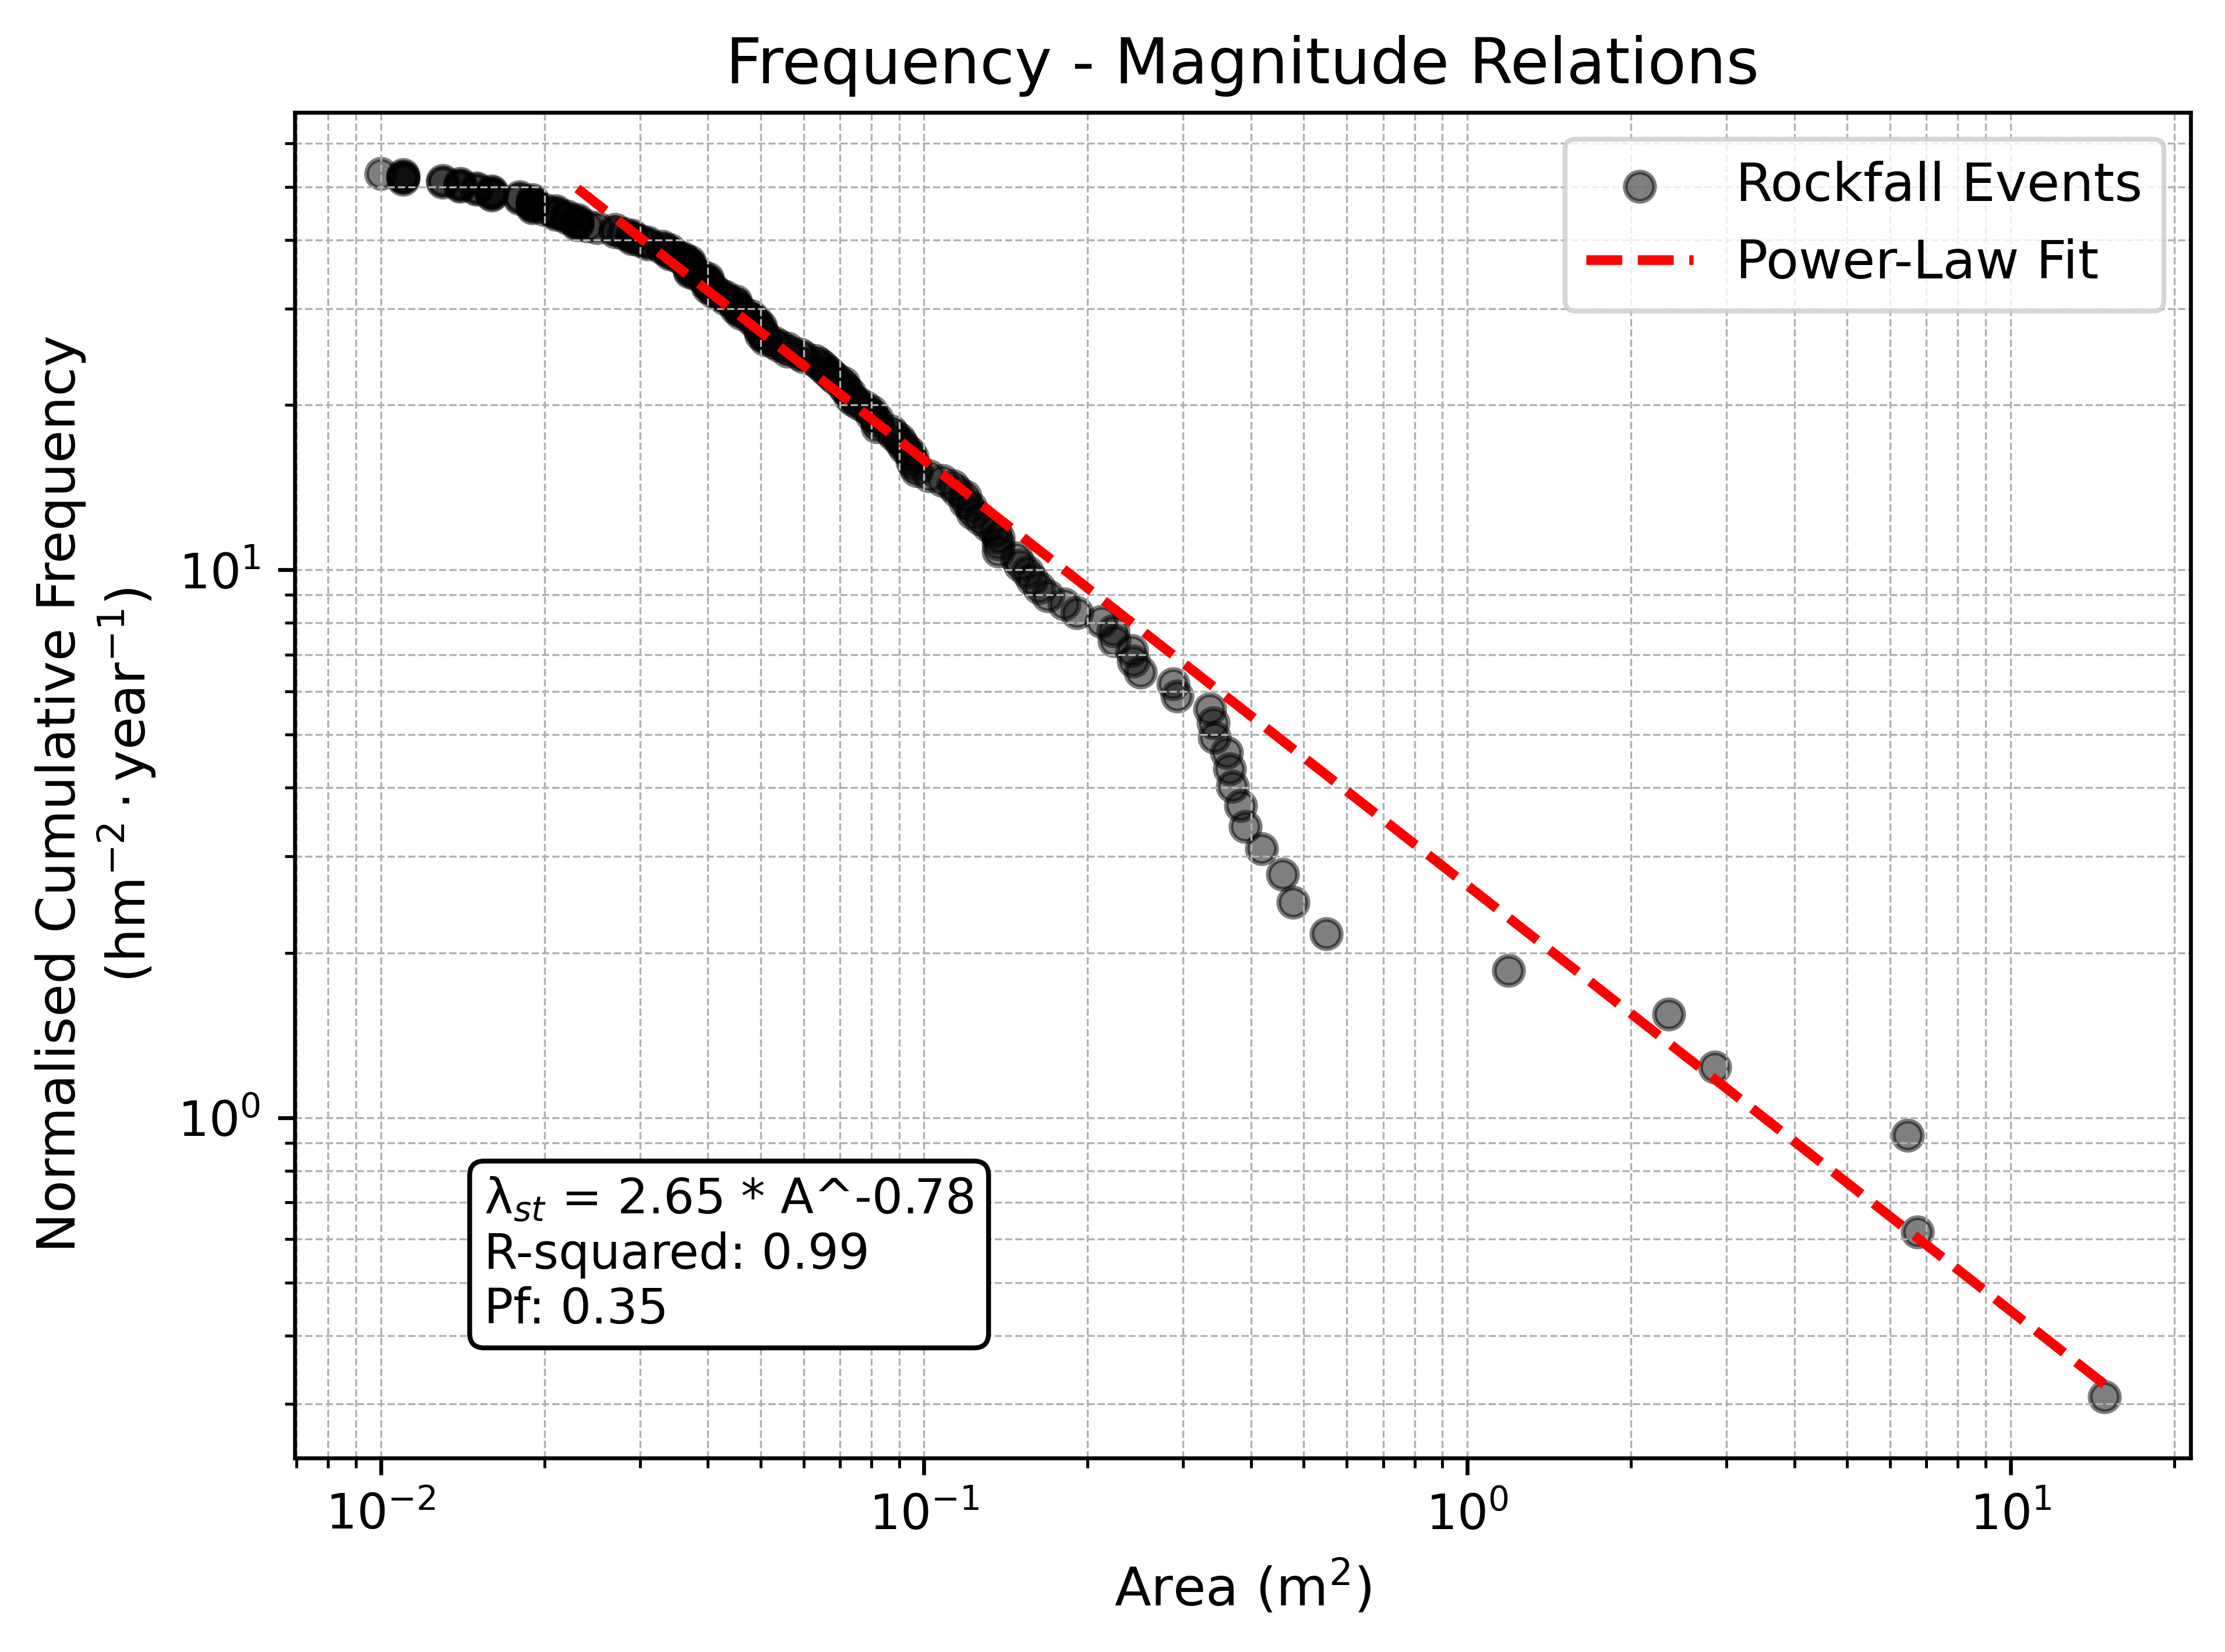

In [29]:
hazard_curve(data, col='area_m', time_interval=time_interval, N=33)

Fitted Parameters for pa: a = 1.3350127446633533, b = -0.8744681214993598
Equation for pa: λ$_{st}$ = 1.34 * A^-0.87
R-squared for pa: 0.9839914540626913
The failure probability of pa is: 0.15
Fitted Parameters for pml: a = 3.3127722814066844, b = -0.8134209804297343
Equation for pml: λ$_{st}$ = 3.31 * A^-0.81
R-squared for pml: 0.9938011552084378
The failure probability of pml is: 0.24


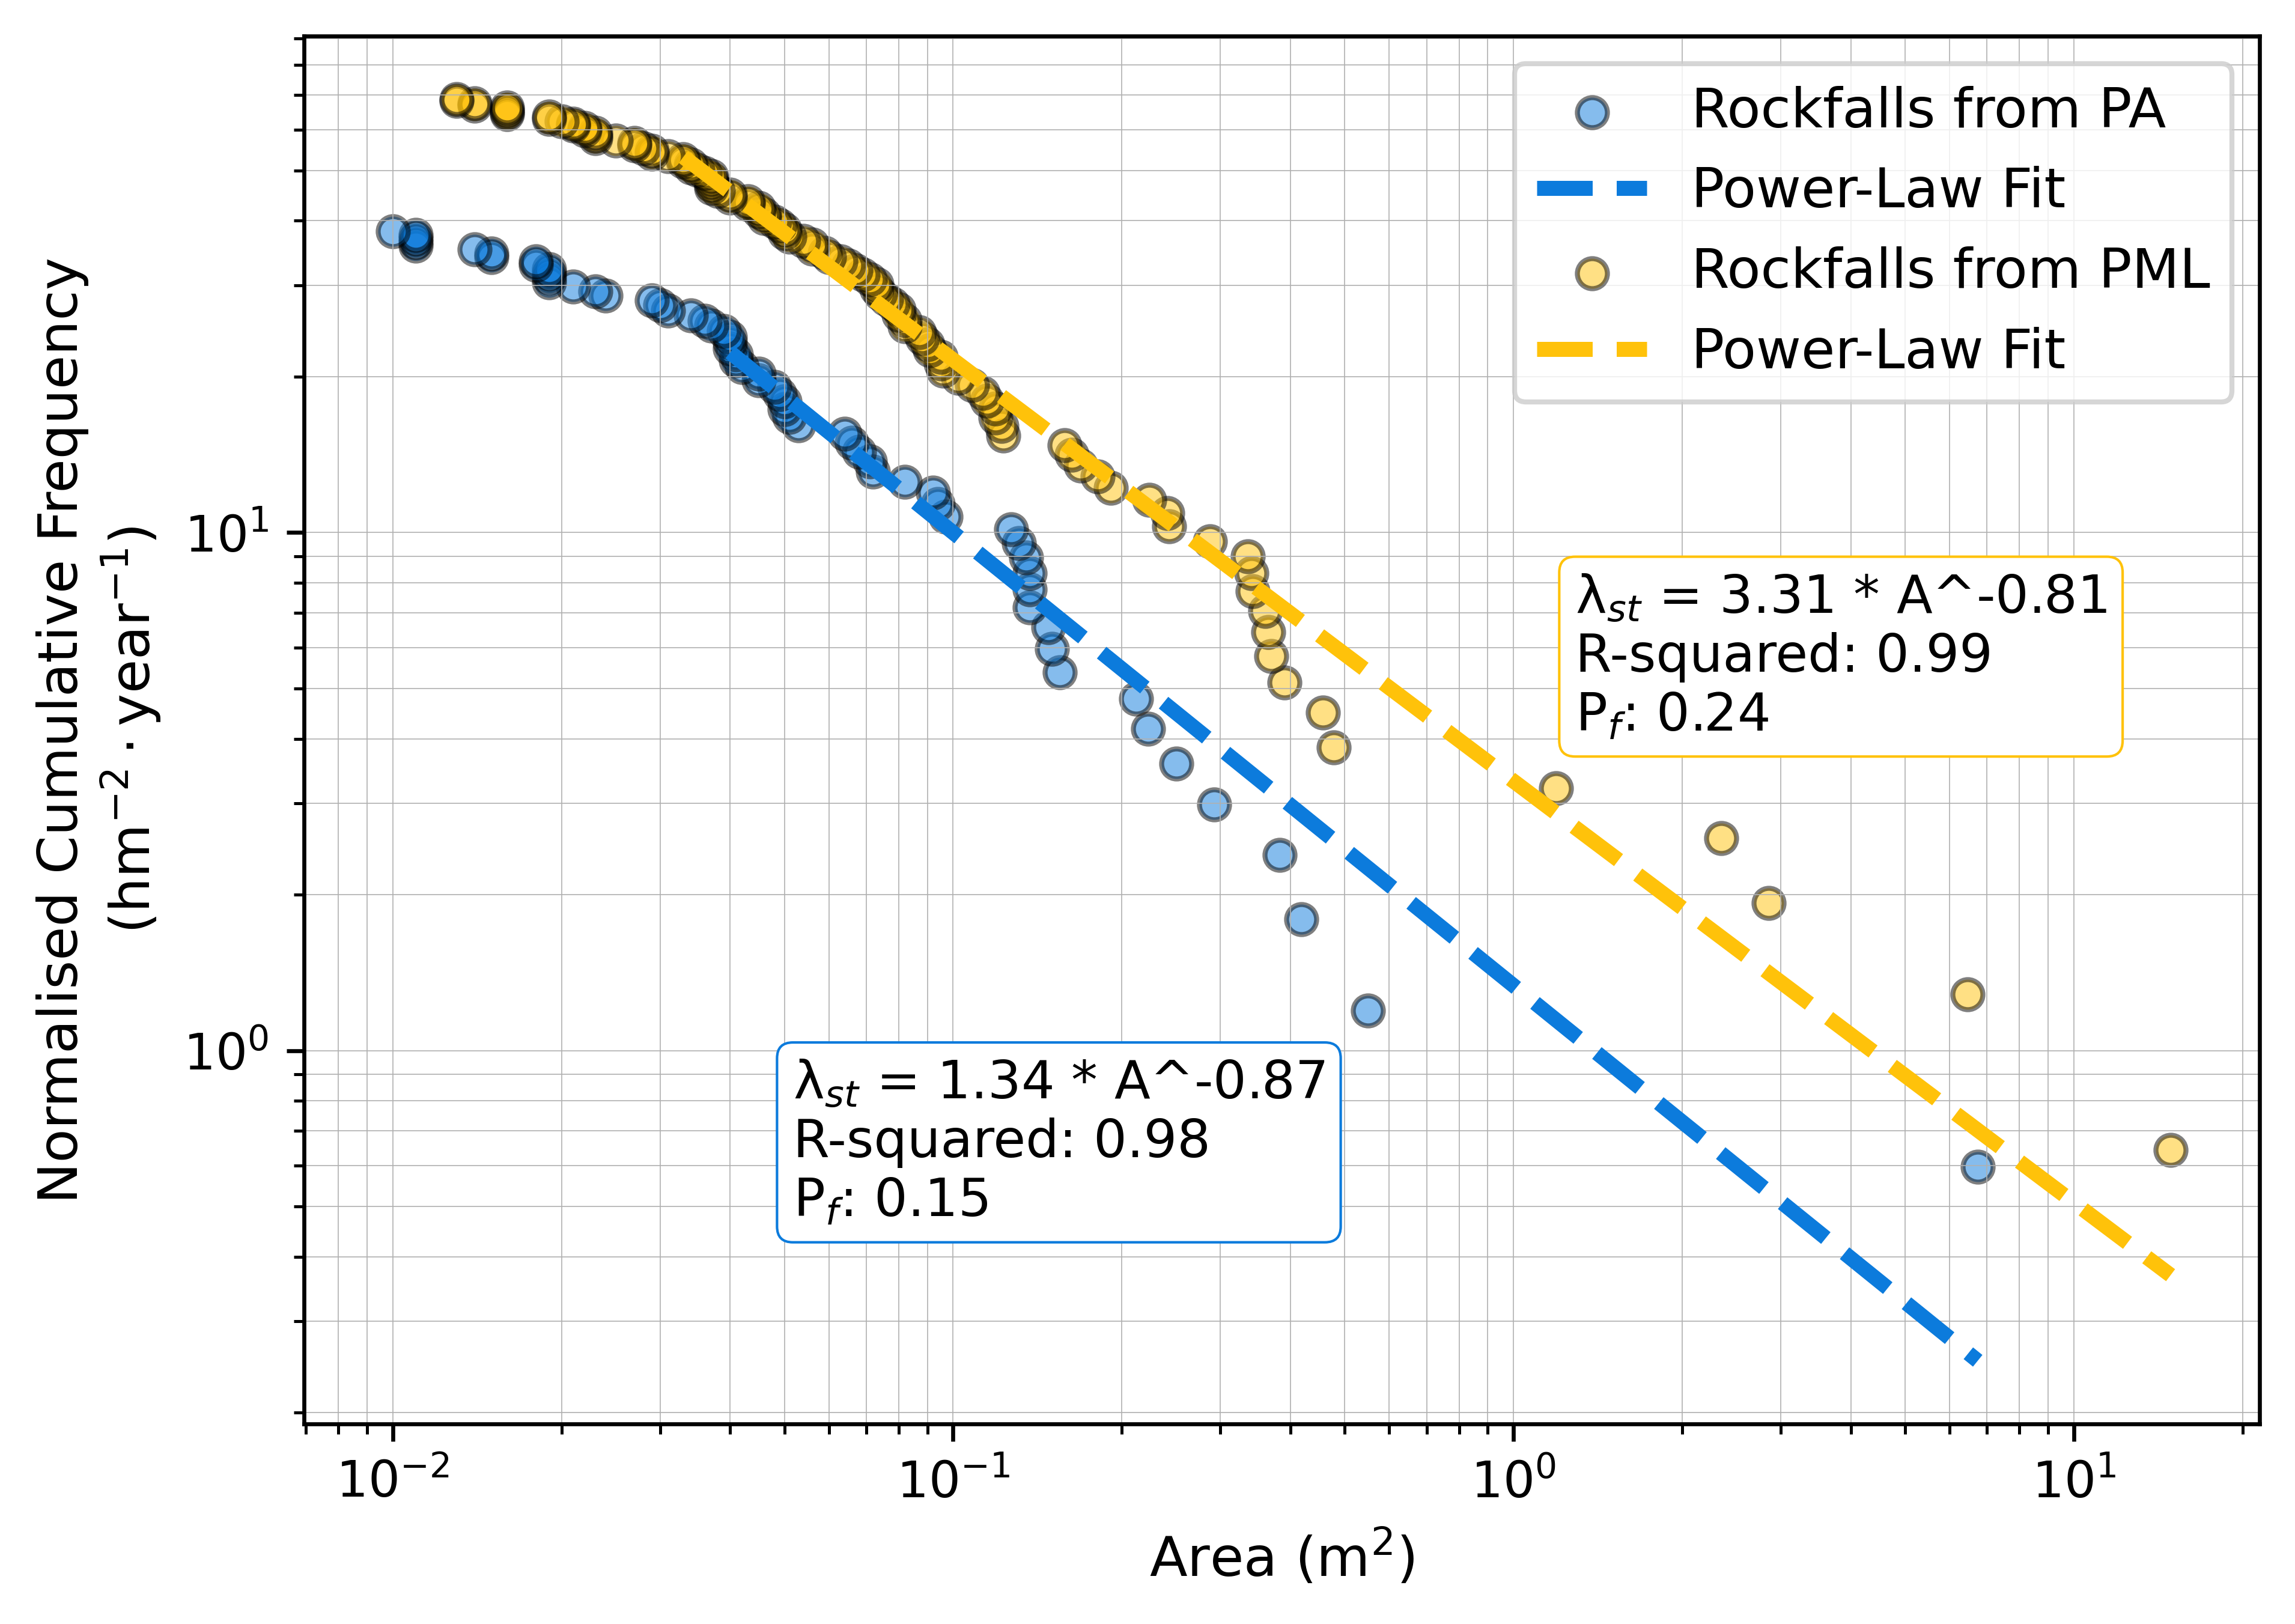

In [30]:
compare_hazard_curve(data, 'area_m', time_interval, by='Membro')

Fitted Parameters for Marl: a = 1.9177257560553174, b = -0.8894037968752437
Equation for Marl: λ$_{st}$ = 1.92 * A^-0.89
R-squared for Marl: 0.9906318178900914
The failure probability of Marl is: 0.16
Fitted Parameters for Sandstone: a = 2.4417330860216477, b = -0.8159585557671003
Equation for Sandstone: λ$_{st}$ = 2.44 * A^-0.82
R-squared for Sandstone: 0.9964093766639787
The failure probability of Sandstone is: 0.22


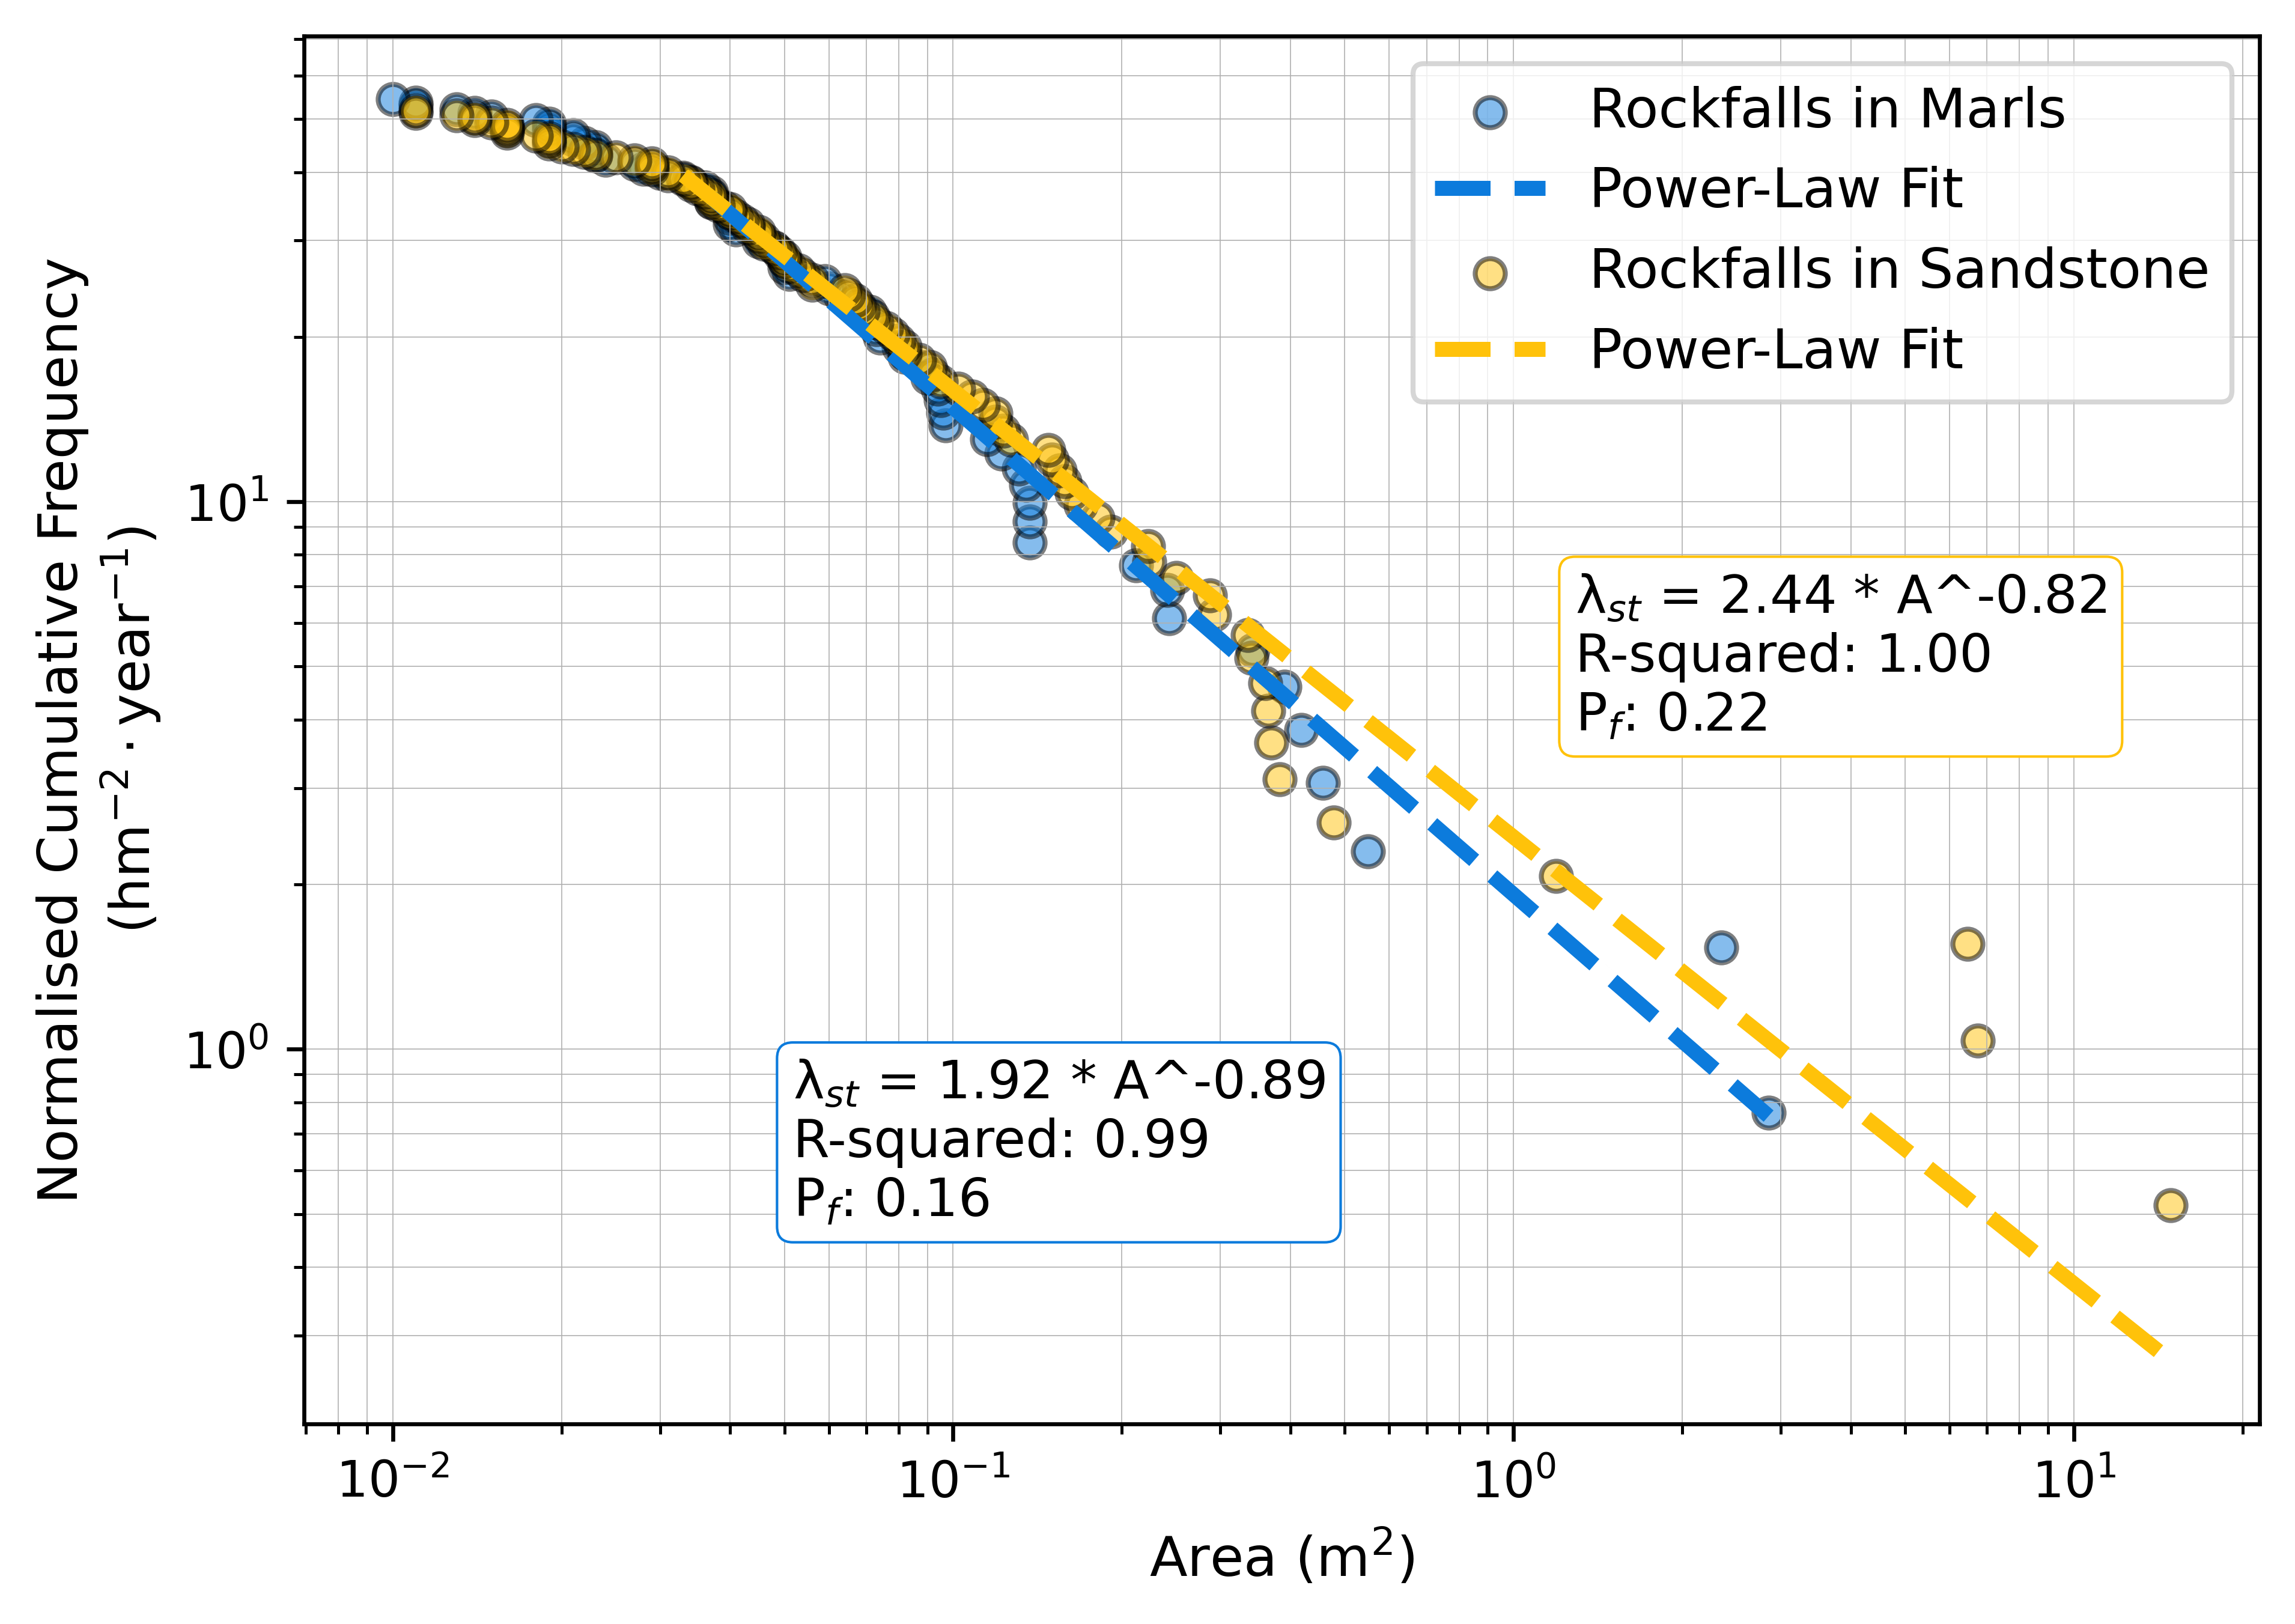

In [31]:
compare_hazard_curve(data, 'area_m', time_interval, by='Litologia')